[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/babbu3682/Med_ChatGPT_tutorial/blob/main/Notebook/colab/Hands_On_Train_Aug_L2.ipynb)

In [ ]:
cd /workspace/sunggu/7.Mentor/Med_ChatGPT_tutorial

In [ ]:
!nvidia-smi
import os
os.environ["CUDA_DEVICE_ORDER"]     =  'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]  =  '6'
print("CPU 갯수 = ", os.cpu_count())

In [ ]:
# !pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117
# !pip freeze > /workspace/sunggu/0.Challenge/requirements.txt
!pip install -r requirements.txt

# 0. Fix Seed

In [ ]:
'''
[Fix Seed]
I want you to act as a AI developer in pytorch and python code for me. 
Fix the randomness of numpy, pytorch, cuda, and random function for reproducibility.
'''

In [ ]:
import random
import numpy as np
import torch

# 시드(seed) 설정
seed = 42

# Python의 random 모듈 시드 설정
random.seed(seed)

# Numpy 시드 설정
np.random.seed(seed)

# Torch 시드 설정
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. Dataset

In [ ]:
'''
[Define Dataset]
I want you to act as a AI developer in pytorch and python code for me. 
Please help with creating the dataset class that process image processing and augmentation based on binary classification deep learning framework.

===INFO===
# data_dir = '/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT/dataset'
# csv_file = 'rsna_data.csv'
data_dir = '/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset'
csv_file = '/content/Med_ChatGPT_tutorial/dataset/rsna_data.csv'
target_class = 'cancer'

Code for creating the RSNA breast cancer dataset class called "RSNA_Dataset". 
This code is a custom dataset class that inherits "Dataset" from PyTorch. 
The dataset can be initialized in either "train" or "valid" mode and reads the file path and label information from the corresponding CSV file.

Each entry in the dataset is defined as follows:
- Read the DICOM file using the image path.
- Apply the Modality Lookup Table (LUT) and Value of Interest (VOI) LUT for the pixel array in the DICOM file.
- Returns the read image and the corresponding label.

In addition to the dataset class, we define an compose transform function that performs data preprocessing and augmentation through the "get_transforms" function using Albumentation Library. 

Please conduct step by step using the following procedure.
	1. In the training mode, perform image resizing (224x224), minmax normalization, change_to_uint8, Contrast Limited Adaptive Histogram Equation (CLAHE), change_to_float32, horizontal flip, brightness and contrast adjustment, Shift-Scale-Rotate conversion, image inversion, minmax normalization, and tensor conversion. 
    2. In validation mode, perform image resizing (224x224), minmax normalization, change_to_uint8, fixed CLAHE, change_to_float32, minmax normalization, and tensor conversion. 
	3. Finally, create "train_dataset" and "valid_dataset" and create a DataLoader that loads them into "train_loader" and "valid_loader". "train_loader" and "valid_loader" can be used for training and validation.

Here is a example template:
<
    import torch
    from torch.utils.data import Dataset

    class MyDataset(Dataset):
    def __init__(self, data_dir):
        # Load the data from the specified directory
        # ...
        
        # Preprocess the data
        # ...

    def __getitem__(self, index):
        # Return the data and labels for the specified index
        # ...

    def __len__(self):
        # Return the number of data samples
        # ...

    # 1. Create Dataset
        # ...
    # 2. Create DataLoader
        # ...
>
'''

In [ ]:
import os
import cv2
import pandas as pd
import pydicom
import skimage
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut


def list_sort_nicely(l):
    def convert(text): return int(text) if text.isdigit() else text
    def alphanum_key(key): return [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

class RSNA_Dataset(Dataset):
    def __init__(self, data_dir, csv_file, target_class, mode="train"):
        self.data_dir = data_dir
        self.csv_file = csv_file
        self.target_class = target_class
        self.mode = mode

        # CSV 파일에서 데이터 로드
        self.df = pd.read_csv(os.path.join(self.data_dir, self.csv_file))
        
        # 해당하는 모드에 따라 데이터 필터링
        self.filtered_df = self.df[self.df['mode'] == self.mode].reset_index(drop=True)

        # Albumentations 변환 함수 정의
        self.transforms = self.get_transforms()

    def __len__(self):
        return len(self.filtered_df)

    def __getitem__(self, idx):
        # 이미지 경로 및 라벨 가져오기
        img_path = self.filtered_df['path'].iloc[idx]
        label = self.filtered_df[self.target_class].iloc[idx]

        # DICOM 파일 읽기 및 처리
        dcm_data = pydicom.dcmread(img_path)
        temp_img = apply_modality_lut(dcm_data.pixel_array, dcm_data)
        image = apply_voi_lut(temp_img, dcm_data)

        # 라벨을 Tensor로 변환
        label = torch.tensor(label).float().unsqueeze(0)

        # 채널 차원 추가
        image = np.expand_dims(image, axis=-1)

        # Albumentations 변환 수행
        transformed = self.transforms(image=image)
        image = transformed['image']

        return image, label

    def get_transforms(self):
        if self.mode == "train":
            return A.Compose([
                A.Resize(224, 224),
                A.Lambda(image=self.min_max_normalization, always_apply=True),
                A.Lambda(image=self.change_to_uint8, always_apply=True),
                A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True),
                
                # Augmentation
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),

                # contrast
                A.OneOf([
                    A.RandomToneCurve(scale=0.3, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2), contrast_limit=(-0.4, 0.5), brightness_by_max=True, always_apply=False, p=0.5),
                    A.InvertImg(p=0.5),
                ], p=0.5),

                # geometric
                A.OneOf(
                    [
                        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=[-0.15, 0.15], rotate_limit=[-30, 30], interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None, shift_limit_x=[-0.1, 0.1], shift_limit_y=[-0.2, 0.2], rotate_method='largest_box', p=0.2),
                        A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None, approximate=False, same_dxdy=False, p=0.2),
                        A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=None, normalized=True, p=0.2),
                    ], p=0.5),

                # Normalize
                A.Lambda(image=self.change_to_float32, always_apply=True),
                A.Lambda(image=self.min_max_normalization, always_apply=True),
                A.Normalize(max_pixel_value=1.0, mean=0.5, std=0.5),
                ToTensorV2()
            ])
        else:
            return A.Compose([
                A.Resize(224, 224),
                A.Lambda(image=self.min_max_normalization, always_apply=True),
                A.Lambda(image=self.change_to_uint8, always_apply=True),
                A.Lambda(image=self.fixed_clahe, always_apply=True),
                A.Lambda(image=self.change_to_float32, always_apply=True),

                # Normalize
                A.Lambda(image=self.min_max_normalization, always_apply=True),
                A.Normalize(max_pixel_value=1.0, mean=0.5, std=0.5),
                ToTensorV2()
            ])
        
    def min_max_normalization(self, image, **kwargs):
        if np.unique(image).size == 1:
            return image    
        image = image.astype('float32')
        image -= image.min()
        image /= image.max()
        return image

    def fixed_clahe(self, image, **kwargs):
        clahe_mat = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe_mat.apply(image)

    def change_to_uint8(self, image, **kwargs):
        return skimage.util.img_as_ubyte(image)

    def change_to_float32(self, image, **kwargs):
        return skimage.util.img_as_float32(image)


In [ ]:
# data_dir = '/workspace/sunggu/7.Mentor/Med_ChatGPT_tutorial/dataset'
# csv_file = 'rsna_data.csv'
data_dir = '/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset'
csv_file = '/content/Med_ChatGPT_tutorial/dataset/rsna_data.csv'
target_class = 'cancer'

# 학습 데이터셋 생성
train_dataset = RSNA_Dataset(data_dir, csv_file, target_class, mode='train')

# 검증 데이터셋 생성
valid_dataset = RSNA_Dataset(data_dir, csv_file, target_class, mode='valid')

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=10)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

# 2. Network

In [ ]:
'''
[Build a Neural Network]
I want you to act as a deep learning expert and code for me. 
I already have a “RSNA_Dataset” of Mammography Breast Cancer. 
Please build a popular or SOTA neural network with pytorch and torchvision.
The input channel is 1 not 3.
The output channel is 1, because the network is used for binary classification task.
Please help with creating the neural network class that predict cancer in binary classification task, and discuss their key features and use cases based on binary classification deep learning framework.

Please conduct step by step using the following procedure.
	1. define the network class "ResNet50".
    2. caculate the number of learnable params.

Here is a example template:
<
import torch.nn as nn
import torchvision

	class Resnet50(nn.Module):
	    def __init__(self, pretrained=True):
	        super().__init__()
	        ...
	        
	    def forward(self, x):
	        ...
>
'''


In [ ]:
import torch.nn as nn
import torchvision

class ResNet50(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=pretrained)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        return self.model(x)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = ResNet50()
num_params = count_parameters(model)
print("Number of learnable parameters: ", num_params)

# 3. Multi-GPU

In [ ]:
'''
[Multi-Gpu Training]
I want you to act as a deep learning expert and code for me. 
Please code for using multi-gpu training (DataParallel) of the model.
First, check the cuda if it is available.
'''

In [ ]:
import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel

# CUDA 사용 가능 여부 확인
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Multi-GPU
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)         
    model = model.to(device)   
else :
    model = model.to(device)

# 4. Loss

In [ ]:
'''
[Define Loss function]
I want you to act as a deep learning expert and code for me. 
I already have a “RSNA_Dataset” of Mammography Breast Cancer. 
Please design a popular loss def function in binary classification task and define the loss as "criterion".
The target and predict(logit) are given in this function and they should be same shape.
The predict is the state before the non-linear activation layer.
Give me a simple example of how to use it.
'''

In [ ]:
import torch
import torch.nn as nn

# 인기 있는 손실 함수인 이진 교차 엔트로피 손실(Binary Cross Entropy Loss)을 사용합니다.
criterion = nn.BCEWithLogitsLoss()

# 예시 사용법
# target = torch.tensor([0, 1, 0, 1])
# logit = torch.tensor([-1.2, 2.5, -0.8, 1.7])
# loss = criterion(logit, target)


# 5. Optimizer

In [ ]:
'''
[Define Optimizer]
I want you to act as a deep learning expert and code for me. 
I already have a “RSNA_Dataset” of Mammography Breast Cancer. 
Please design some popular or SOTA optimizers in binary classification network.
Learning rate is 1e-4.
weight_dacay is 0.
Other optimizer's params are set default.
Please discuss optimizer hyperparams' key features and use cases.
'''

In [ ]:
import torch.optim as optim

# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
# optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=0)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=5e-2) 


# 6. LR scheduler

In [ ]:
'''
[Define learning rate(LR) scheduler]
I want you to act as a deep learning expert and code for me. 
Please design some popular or SOTA LR schedulers in binary classification network.
LR scheduler's params are set default.
Please discuss LR scheduler hyperparams' key features and use cases.
'''

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

# scheduler = lr_scheduler.StepLR(optimizer)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

# 7. Check the resume point

In [ ]:
'''
[Resume training]
I want you to act as a deep learning expert and code for me. 
Please code for loading the model weight from the checkpoint if it is exist.

==INFO===
start_epoch     = 0
total_epoch     = 1000

# checkpoint_dir  = '/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT/checkpoints/230701_ResNet50_Aug_L2'
# save_dir        = '/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT/predictions/230701_ResNet50_Aug_L2'

checkpoint_dir  = '/content/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Aug_L2'
save_dir        = '/content/Med_ChatGPT_tutorial/predictions/230701_ResNet50_Aug_L2'

checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pth')


Please conduct step by step using the following procedure.
    1. make checkpoints and prediction folders if not exist (using exist_ok=True)
    2. load model, optimizer, scheduler, start_epoch
'''

In [ ]:
start_epoch     = 0
total_epoch     = 200

# checkpoint_dir  = '/workspace/sunggu/7.Mentor/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Aug_L2'
# save_dir        = '/workspace/sunggu/7.Mentor/Med_ChatGPT_tutorial/predictions/230701_ResNet50_Aug_L2'
checkpoint_dir  = '/content/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Aug_L2'
save_dir        = '/content/Med_ChatGPT_tutorial/predictions/230701_ResNet50_Aug_L2'

import os

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

In [ ]:
checkpoint_path = checkpoint_dir + '/' + 'epoch_41_checkpoint.pth'

# 체크포인트 파일이 존재하는 경우 모델 가중치 로드
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

print("모델 가중치를 체크포인트에서 성공적으로 불러왔습니다.")

# 8. Metric

In [ ]:
'''
[Define Metrics]
I want you to act as a deep-learning expert and code for me. 
Please def function code for metrics in binary classification for cancer detection.
Here is what I want metrics: AUC, accuracy, f1, sensitivity, specificity...
Give me a simple example of how to use it.
'''

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, confusion_matrix, precision_score

def calculate_metrics(predictions, targets):
    # AUC 계산
    auc = roc_auc_score(targets, predictions)

    # 정확도 계산
    accuracy = accuracy_score(targets, np.round(predictions))

    # F1 점수 계산
    f1 = f1_score(targets, np.round(predictions))

    # 민감도 (재현율) 계산
    sensitivity = recall_score(targets, np.round(predictions))

    # 특이도 계산
    tn, fp, fn, tp = confusion_matrix(targets, np.round(predictions)).ravel()
    specificity = tn / (tn + fp)

    return auc, accuracy, f1, sensitivity, specificity

# # 예시 사용법
# predictions = [0.8, 0.3, 0.6, 0.9]
# targets = [1, 0, 0, 1]
# auc, accuracy, f1, sensitivity, specificity = calculate_metrics(predictions, targets)


# 9. Training & Validation Loop

In [ ]:
'''
[Define Training & Validation Loop function]
I want you to act as a deep-learning expert and code for me. 
Please create the loop def function code for training and validation. 
In this code, you will use the AverageMeter class to calculate the average of the metrics, and the train_loop_fn function and the valid_loop_fn function to perform the training and validation process. 
In addition, the train_loop_fn function and the valid_loop_fn function will utilize a loss function (criterion) to calculate the loss, which will be used to calculate the metrics using 'calculate_metrics' function (accuracy, F1, AUC, sensitivity, and specificity).

Please conduct step by step using the following procedure.
	1. understand the AverageMeter class and how it calculates the average of the metrics.
	2. understand the structure and role of the train_loop_fn and valid_loop_fn functions.
	3. see how to utilize the loss function (criterion) to calculate loss.
	4. understand how to calculate the metrics (accuracy, F1, AUC, sensitivity, specificity) using calculate_metrics function used in the train_loop_fn and valid_loop_fn functions.
	5. train_loader, model, criterion, optimizer, device, epoch are given in train_loop_fn.
	6. valid_loader, model, criterion, device, epoch are given in valid_loop_fn.
    7. analyze the methods (update, average) of AverageMeter that are called by the train_loop_fn and valid_loop_fn functions.
	8. Implement a training and validation loop based on the given code, and check the resulting metrics.
'''

In [ ]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import math

class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.data = defaultdict(lambda: {'sum': 0, 'count': 0})

    def update(self, key, value, n):
        self.data[key]['sum'] += value * n
        self.data[key]['count'] += n
    
    def average(self):
        return {k: v['sum'] / v['count'] for k, v in self.data.items()}

def train_loop_fn(train_loader, model, criterion, optimizer, device, epoch):
    model.train()
    metric_logger = AverageMeter()
    # epoch_iterator = tqdm(train_loader, desc=f"Training (Epoch {epoch})")
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True, total=len(train_loader))

    for step, batch_data in enumerate(epoch_iterator):
        image, target = batch_data
        image, target = image.to(device), target.to(device)

        logit = model(image)
        loss = criterion(logit, target)
        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metric_logger.update(key='train_loss', value=loss_value, n=image.shape[0])
        epoch_iterator.set_description("Training: Epochs %d (%d / %d Steps), (train_loss=%2.5f)" % (epoch, step, len(train_loader), loss_value))
        # epoch_iterator.set_postfix(loss=loss_value)

    # return {k: round(v, 7) for k, v in metric_logger.average().items()}
    return metric_logger.average()
    

@torch.no_grad()
def valid_loop_fn(valid_loader, model, criterion, device):
    model.eval()
    metric_logger = AverageMeter()
    # epoch_iterator = tqdm(valid_loader, desc="Validating")
    epoch_iterator = tqdm(valid_loader, desc="Validating (X / X Steps) (loss=X.X)", dynamic_ncols=True, total=len(valid_loader))

    preds = []
    gts = []
    for batch_data in epoch_iterator:
        image, target = batch_data
        image, target = image.to(device), target.to(device)

        logit = model(image)
        loss = criterion(logit, target)
        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))

        metric_logger.update(key='valid_loss', value=loss_value, n=image.shape[0])
        # epoch_iterator.set_postfix(loss=loss_value)
        epoch_iterator.set_description("Validating: (valid_loss=%2.5f)" % (loss_value))

        preds.append(logit.sigmoid().squeeze().detach().cpu().numpy())
        gts.append(target.squeeze().detach().cpu().numpy())

    preds = np.stack(preds)
    gts = np.stack(gts)

    # Calculate metrics
    auc, accuracy, f1, sensitivity, specificity = calculate_metrics(preds, gts)

    metric_logger.update(key='valid_loss', value=loss.item(), n=image.size(0))
    metric_logger.update(key='valid_auc', value=auc, n=image.size(0))
    metric_logger.update(key='valid_accuracy', value=accuracy, n=image.size(0))
    metric_logger.update(key='valid_f1', value=f1, n=image.size(0))
    metric_logger.update(key='valid_sensitivity', value=sensitivity, n=image.size(0))
    metric_logger.update(key='valid_specificity', value=specificity, n=image.size(0))

    return metric_logger.average()
    # return {k: round(v, 7) for k, v in metric_logger.average().items()}


In [ ]:
'''
[Implementation Training & Validation]
I want you to act as a deep-learning expert and code for me. 
You are given a code that trains a model using a training loop and performs validation using a validation loop. 
The code also includes functionality for saving checkpoints, updating the learning rate scheduler, and logging the training and validation statistics. 

Please conduct step by step using the following procedure:
	Step 1: Import the necessary libraries and modules for the code, including warnings, time, and datetime.
	Step 2: Set up a warning filter to ignore any warnings that occur during execution.
	Step 3: Print a message indicating the start of the training process.
	Step 4: Start a loop that iterates over the specified number of epochs, ranging from the start_epoch to the total_epoch.
	Step 5: Within each epoch, call the train_loop_fn function to perform the training process. Pass the train_loader, model, criterion, optimizer, device, and current epoch as arguments. Store the returned training statistics in a variable.
	Step 6: Print the averaged training statistics.
	Step 7: Call the valid_loop_fn function to perform the validation process. Pass the valid_loader, model, criterion, device, and current epoch as arguments. Also, provide the save_dir where the checkpoints will be saved. Store the returned validation statistics in a variable.
	Step 8: Print the averaged validation statistics.
	Step 9: Adjust the learning rate scheduler using the valid_loss from the validation statistics.
	Step 10: Save a checkpoint of the current model, including the epoch, model_state_dict, optimizer_state_dict, and scheduler_state_dict. The checkpoint should be saved in a designated checkpoint_path with a filename that includes the epoch number.
	Step 11: Log the training and validation statistics, including the epoch, learning rate, and both train and valid statistics. The statistics should be stored in a log file located in the checkpoint_path.
	Step 12: Repeat steps 4-11 until all epochs have been completed.
	Step 13: Calculate the total training time by subtracting the start_time from the current time. Format the total time as a human-readable string.
	Step 14: Print the total training time.
'''

In [ ]:
import warnings
import time
import datetime
import json

warnings.filterwarnings(action='ignore')

print("학습 시작")
start_time = time.time()

for epoch in range(start_epoch, total_epoch):
    train_stats = train_loop_fn(train_loader, model, criterion, optimizer, device, epoch)
    print("==> 평균 학습 통계: " + str(train_stats))
    
    valid_stats = valid_loop_fn(valid_loader, model, criterion, device)
    print("==> 평균 검증 통계: " + str(valid_stats))

    # 학습률 스케줄러 업데이트
    scheduler.step(valid_stats['valid_loss'])

    # 체크포인트 저장
    checkpoint_path = f"{checkpoint_dir}/epoch_{epoch}_checkpoint.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.module.state_dict() if hasattr(model, 'module') else model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

    # 로그 기록
    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()}, 
                 **{f'valid_{k}': v for k, v in valid_stats.items()}, 
                 'epoch': epoch,
                 'lr': optimizer.param_groups[0]['lr']}
      
    with open(f"{checkpoint_dir}/log.txt", "a") as f:
        f.write(json.dumps(log_stats) + "\n")

# 학습 완료
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('학습 시간: {}'.format(total_time_str))


# Testing Process

## 1. Log 조사

In [ ]:
'''
[Log analysis]
I want you to act as an AI developer in pytorch and python code for me. 
Please help with coding for implementing the ability to read data from a log file and visualize it in a graph.

Please conduct step by step using the following procedure:
	Step 1: Import the necessary libraries and modules: glob, numpy, matplotlib.pyplot.
	Step 2: Define a read_log function to read a log file. This function takes a file path as an argument, reads the log file, and returns it as a list.
	Step 3: Read the log file using the read_log function. Specify the path as '/workspace/sunggu/0.Challenge/Med_tutorial_ChatGPT/checkpoints/230615_ResNet50_L2_Reg/log.txt'. The read log file is stored in the log_list variable.
	Step 4: Create a dictionary, result_dict, to store the results. Initialize result_dict with the keys from the first dictionary in log_list.
	Step 5: Extract the value corresponding to each key in result_dict from log_list and save it as a list.
	Step 6: Generate a graph. To visualize the results, use matplotlib.pyplot's subplots function. The number of graphs is equal to the number of keys in result_dict, and they are laid out in a vertical orientation. Set the size of the graph via figsize.
	Step 7: Generate a graph for each key in result_dict through a for loop. axs[idx] indicates the subplot to plot at the position corresponding to idx.
	Step 8: Plot the data on the generated graphs. result_dict[key] takes the data corresponding to key and plots the graph. axs[idx].set_title(key) sets the title of the graph to key.
	Step 9: Display the graph. After adjusting the spacing of the graph with plt.tight_layout(), call plt.show() to output the graph.
'''

###########################################################
Metric  =  train_train_loss
Argsort =  [57 56 58 55 41]
Value   =  [0.34430791 0.35328039 0.36520309 0.37941213 0.38086113]
###########################################################
Metric  =  valid_valid_loss
Argsort =  [ 4 18 17  2 16]
Value   =  [0.67502752 0.6754954  0.67637049 0.67655718 0.67723249]
###########################################################
Metric  =  valid_valid_auc
Argsort =  [29 27 26 59 46]
Value   =  [0.6827981  0.6827981  0.68272376 0.68250074 0.68235207]
###########################################################
Metric  =  valid_valid_accuracy
Argsort =  [53 62 58 19 39]
Value   =  [0.65086207 0.65086207 0.65086207 0.65086207 0.65086207]
###########################################################
Metric  =  valid_valid_f1
Argsort =  [14 26 53 39 62]
Value   =  [0.68181818 0.67953668 0.6746988  0.6746988  0.6746988 ]
###########################################################
Metric  =  valid_va

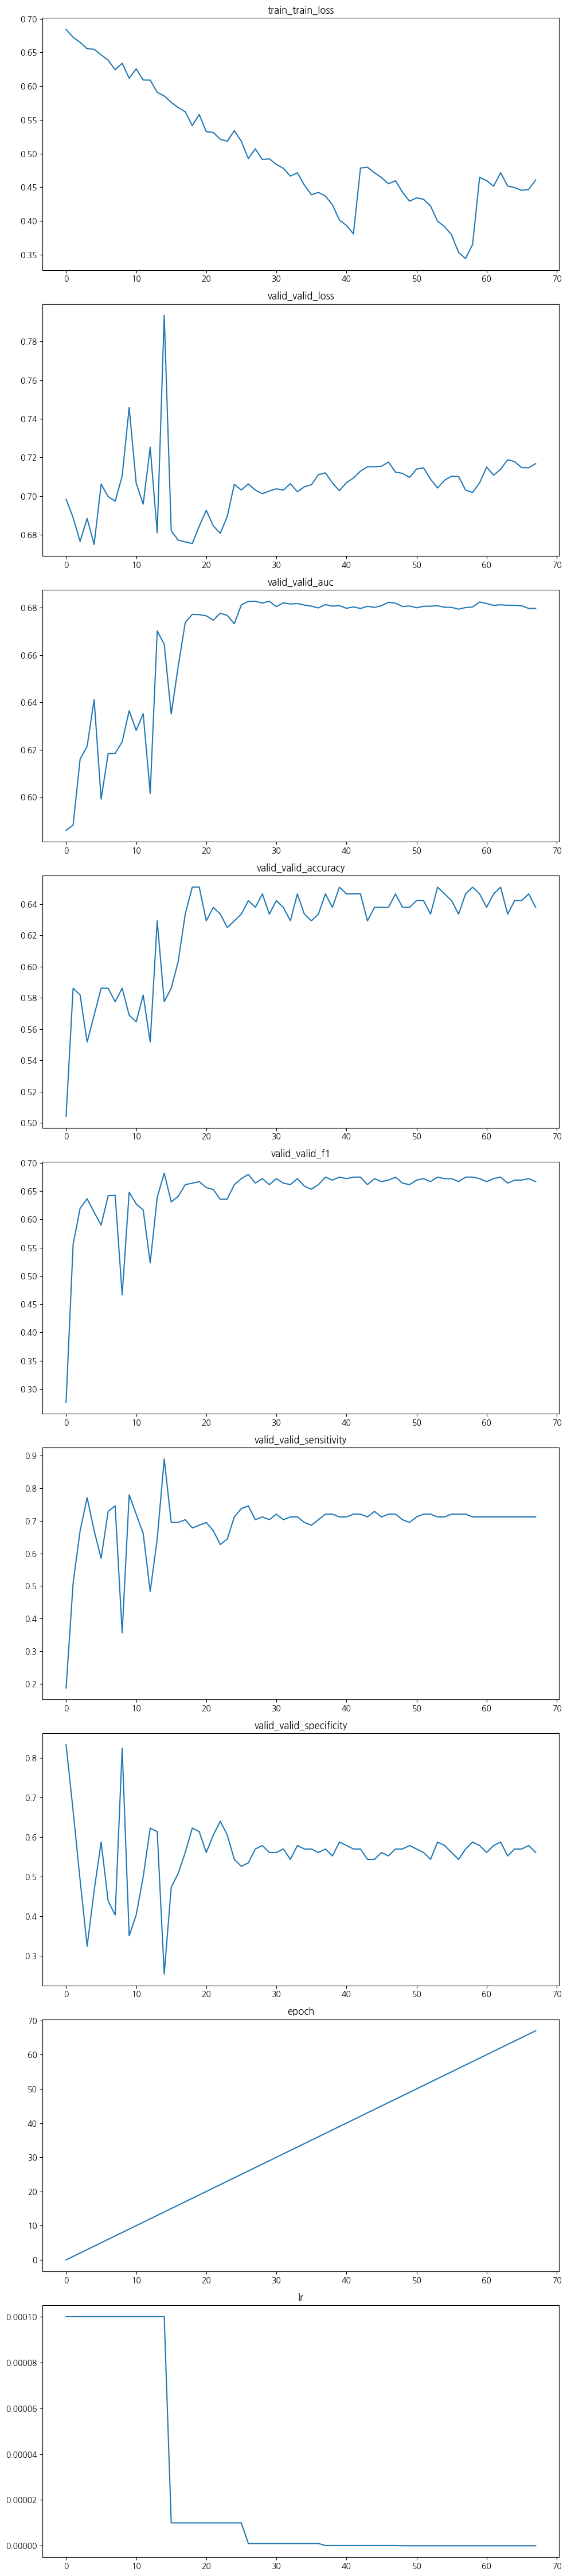

In [27]:
import glob
import numpy as np
import matplotlib.pyplot as plt

def read_log(path):
    log_list = []
    lines = open(path, 'r').read().splitlines() 
    for line in lines:
        log_list.append(eval(line))
    return log_list

log_list = read_log(path='/workspace/sunggu/7.Mentor/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Aug_L2/log.txt')

result_dict = {}
for key in log_list[0].keys():
    result_dict[key] = [log[key] for log in log_list]

fig, axs = plt.subplots(len(result_dict.keys()), 1, figsize=(10, len(result_dict.keys())*5))

for idx, key in enumerate(result_dict.keys()):
    axs[idx].plot(result_dict[key])
    axs[idx].set_title(key)
    print("###########################################################")
    print("Metric  = ", key)
    
    if "loss" in key:
        print("Argsort = ", np.argsort(result_dict[key])[:5])
        print("Value   = ", np.array(result_dict[key])[np.argsort(result_dict[key])[:5]])
    else:
        print("Argsort = ", np.argsort(result_dict[key])[::-1][:5])
        print("Value   = ", np.array(result_dict[key])[np.argsort(result_dict[key])[::-1][:5]])

plt.tight_layout()
plt.show()


## 2. Test Dataset

In [28]:
# TEST 데이터셋 생성
test_dataset = RSNA_Dataset(data_dir, csv_file, target_class, mode='test')

# DataLoader 생성
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

## 3. Load Checkpoint

In [29]:
# Metric  =  valid_valid_accuracy
# Argsort =  [53 62 58 19 39]
# Value   =  [0.65086207 0.65086207 0.65086207 0.65086207 0.65086207]

filename = 'epoch_53_checkpoint.pth'
print("=> loading checkpoint '{}'".format(filename))
checkpoint  = torch.load(os.path.join(checkpoint_dir, filename))
model.load_state_dict(checkpoint['model_state_dict'])

=> loading checkpoint 'epoch_53_checkpoint.pth'


<All keys matched successfully>

## 4. Using GPU testing

In [30]:
# using CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## 5. Test Loop

In [31]:
'''
[Define Test Loop function]
I want you to act as an AI developer in pytorch and python code for me. 
Please help with writing a code that performs testing on a model using a testing loop. 
In this code, you will use the AverageMeter class to calculate the average of the metrics, and the test_loop_fn function to perform the testing process.
The code includes functionalities such as calculating metrics, generating Grad-CAM visualizations, and saving the visualizations.
In addition, the test_loop_fn function will utilize a loss function (criterion) to calculate the loss, which will be used to calculate the metrics using 'calculate_metrics' function (accuracy, F1, AUC, sensitivity, and specificity).
The model predicts cancer within an image in a binary classification manner.

Please conduct step by step using the following procedure:
	Step 1: Import the necessary libraries and modules for the code, including time, math, json, tqdm, datetime, matplotlib.pyplot, and defaultdict.
	Step 2: Define the AverageMeter class, which will be used to calculate the average of metrics.
	Step 3: Define the forward_hook function, which serves as the forward hook for capturing intermediate activations.
	Step 4: Define the backward_hook function, which serves as the backward hook for capturing gradients.
	Step 5: Define the min_max_normalization function, which performs min-max normalization on the input image.
	Step 6: Define the test_loop_fn function, which performs testing using the provided model, criterion, and data. The function takes the test_loader, model, criterion, device, and save_dir as arguments.
	Step 7: Set the model to evaluation mode.
	Step 8: Initialize the metric_logger to track the metrics during testing.
	Step 9: Iterate over the batches in the test_loader using the tqdm iterator.
	Step 10: Get the input images and targets from the batch.
	Step 11: Register the forward_hook and backward_hook on the specified layer of the model (resnet50's layer4[2].conv3).
	Step 12: Pass the input images through the model to obtain the logits.
	Step 13: Calculate the loss using the criterion.
	Step 14: Update the metric_logger with the loss value.
	Step 15: Perform post-processing steps, such as storing the predicted probabilities and ground truth values.
	Step 16: Calculate the Grad-CAM visualization by computing the gradients and activations.
	Step 17: Resize the Grad-CAM heatmap to the original image size.
	Step 18: Visualize the image and Grad-CAM heatmap using matplotlib.pyplot.
	Step 19: Save the visualization to a file in the specified save_dir.
	Step 20: Remove the forward_hook and backward_hook.
	Step 21: Concatenate the predicted probabilities and ground truth values to calculate metrics.
	Step 22: Calculate the metrics (AUC, accuracy, F1, sensitivity, specificity) using the calculate_metrics function.
	Step 23: Update the metric_logger with the calculated metrics.
	Step 24: Return the average of the metrics and the ground truth values.

Here is a valid_loop example, so you can refer to it:
<
@torch.no_grad()
def valid_loop_fn(valid_loader, model, criterion, device):
    model.eval()
    metric_logger = AverageMeter()
    # epoch_iterator = tqdm(valid_loader, desc="Validating")
    epoch_iterator = tqdm(valid_loader, desc="Validating (X / X Steps) (loss=X.X)", dynamic_ncols=True, total=len(valid_loader))

    preds = []
    gts = []
    for batch_data in epoch_iterator:
        image, target = batch_data
        image, target = image.to(device), target.to(device)

        logit = model(image)
        loss = criterion(logit, target)
        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))

        metric_logger.update(key='valid_loss', value=loss_value, n=image.shape[0])
        # epoch_iterator.set_postfix(loss=loss_value)
        epoch_iterator.set_description("Validating: Epochs %d (%d / %d Steps), (valid_loss=%2.5f)" % (epoch, step, len(valid_loader), loss_value))

        preds.append(logit.sigmoid().squeeze().detach().cpu().numpy())
        gts.append(target.squeeze().detach().cpu().numpy())

    preds = np.concatenate(preds)
    gts = np.concatenate(gts)

    # Calculate metrics
    auc, accuracy, f1, sensitivity, specificity = calculate_metrics(preds, gts)

    metric_logger.update(key='valid_loss', value=loss.item(), n=image.size(0))
    metric_logger.update(key='valid_auc', value=auc, n=image.size(0))
    metric_logger.update(key='valid_accuracy', value=accuracy, n=image.size(0))
    metric_logger.update(key='valid_f1', value=f1, n=image.size(0))
    metric_logger.update(key='valid_sensitivity', value=sensitivity, n=image.size(0))
    metric_logger.update(key='valid_specificity', value=specificity, n=image.size(0))

    return metric_logger.average()
>
'''

'\n[Define Test Loop function]\nI want you to act as an AI developer in pytorch and python code for me. \nPlease help with writing a code that performs testing on a model using a testing loop. \nIn this code, you will use the AverageMeter class to calculate the average of the metrics, and the test_loop_fn function to perform the testing process.\nThe code includes functionalities such as calculating metrics, generating Grad-CAM visualizations, and saving the visualizations.\nIn addition, the test_loop_fn function will utilize a loss function (criterion) to calculate the loss, which will be used to calculate the metrics using \'calculate_metrics\' function (accuracy, F1, AUC, sensitivity, and specificity).\nThe model predicts cancer within an image in a binary classification manner.\n\nPlease conduct step by step using the following procedure:\n\tStep 1: Import the necessary libraries and modules for the code, including time, math, json, tqdm, datetime, matplotlib.pyplot, and defaultdic

In [34]:
import time
import math
import json
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

class AverageMeter:
    def __init__(self, **kwargs):
        self.reset()

    def reset(self):
        self.data = defaultdict(lambda: {'sum': 0, 'count': 0})

    def update(self, key, value, n):
        self.data[key]['sum']   += value * n
        self.data[key]['count'] += n
    
    def average(self):
        return {k: v['sum'] / v['count'] for k, v in self.data.items()}

# forward hook 정의
def forward_hook(module, input, output):
    global activations
    activations = output.detach()

# backward hook 정의
def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

def min_max_normalization(image, **kwargs):
    if np.unique(image).size == 1: # Sometimes it cause the nan inputs...
        return image    
    image = image.astype('float32')
    image -= image.min()
    image /= image.max()
    return image


# @torch.no_grad() -> grad cam을 그릴려면 꺼야한다.
def test_loop_fn(valid_loader, model, criterion, device, save_dir):
    model.eval()
    metric_logger  = AverageMeter()
    epoch_iterator = tqdm(valid_loader, desc="Testing (X / X Steps) (loss=X.X)", dynamic_ncols=True, total=len(valid_loader))

    preds = [] # must be 1d list or array
    gts   = [] # must be 1d list or array
    for step, batch_data in enumerate(epoch_iterator):
        image, target = batch_data
        image, target = image.to(device), target.to(device)
        
        if hasattr(model, 'module'):
            handle_forward  = model.module.model.layer4[2].conv3.register_forward_hook(forward_hook)
            handle_backward = model.module.model.layer4[2].conv3.register_backward_hook(backward_hook)
        
        else: 
            handle_forward  = model.model.layer4[2].conv3.register_forward_hook(forward_hook)
            handle_backward = model.model.layer4[2].conv3.register_backward_hook(backward_hook)

        logit = model(image)
        loss  = criterion(logit, target)
        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))

        metric_logger.update(key='test_loss', value=loss_value, n=image.shape[0])
        epoch_iterator.set_description("Testing: (%d / %d Steps), (test_loss=%2.5f)" % (step, len(valid_loader), loss_value))

        # post-processing
        preds.append(logit.sigmoid().squeeze().detach().cpu().numpy())
        gts.append(target.squeeze().detach().cpu().numpy())

        # Grad-CAM
        model.zero_grad()
        logit[:, 0].backward() # score(=scalar)에 대한 gradient 계산. Backward pass with specific '0' class

            # gradients, activations 처리
        weights  = torch.mean(gradients, dim=(2, 3), keepdim=True)            # gradients   = torch.Size([1(=B), 2048, 7, 7])
        grad_cam = torch.sum(weights * activations, dim=1, keepdim=True)      # weights     = torch.Size([1(=B), 2048, 1, 1]),  [B, C, 1, 1] * [B, C, H, W] = [B, 1, H, W]
        grad_cam = torch.relu(grad_cam)                                       # activations = torch.Size([1(=B), 2048, 7, 7])
                                                                              # grad_cam    = torch.Size([1(=B), 1,    7, 7])

            # 시각화를 위해 이미지 크기로 업샘플링
        upsampled_grad_cam = torch.nn.functional.interpolate(grad_cam, size=(224, 224), mode='bilinear', align_corners=False)
        heatmap = upsampled_grad_cam.squeeze().detach().cpu().numpy() # [H, W]

            # 이미지와 Grad-CAM 시각화
        # plt.figure(figsize=(10, 10)
        plt.imshow(image.squeeze().detach().cpu().numpy()) # [H, W]
        plt.imshow(min_max_normalization(heatmap), alpha=0.4, cmap='jet') # [H, W]
        plt.axis('off')
        # plt.title('/gradcam_s[' + str(step) + ']_p[' + str(logit.sigmoid().squeeze().detach().cpu().numpy())[:4] + ']_g[' + str(target.squeeze().detach().cpu().numpy()) + ']')
        # plt.show()
        plt.savefig(save_dir + '/gradcam_s[' + str(step) + ']_p[' + str(logit.sigmoid().squeeze().detach().cpu().numpy())[:4] + ']_g[' + str(target.squeeze().detach().cpu().numpy()) + '].jpg', bbox_inches='tight', pad_inches=0)
        plt.close()        

            # Hook 제거
        handle_forward.remove()
        handle_backward.remove()       


    # Metric Calculation
    preds = np.stack(preds)
    gts = np.stack(gts)

    # Calculate metrics
    auc, accuracy, f1, sensitivity, specificity = calculate_metrics(preds, gts)

    metric_logger.update(key='test_loss', value=loss.item(), n=image.size(0))
    metric_logger.update(key='test_auc', value=auc, n=image.size(0))
    metric_logger.update(key='test_accuracy', value=accuracy, n=image.size(0))
    metric_logger.update(key='test_f1', value=f1, n=image.size(0))
    metric_logger.update(key='test_sensitivity', value=sensitivity, n=image.size(0))
    metric_logger.update(key='test_specificity', value=specificity, n=image.size(0))

    return metric_logger.average()

In [36]:
import time
import warnings
warnings.filterwarnings(action='ignore')

print(f"Start training")
start_time = time.time()
    
test_stats = test_loop_fn(test_loader, model, criterion, device, save_dir)
print('==> Averaged Test stats: ' + str(test_stats))

# Finish
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

Start training


Testing: (231 / 232 Steps), (test_loss=0.49053): 100%|██████████| 232/232 [01:12<00:00,  3.19it/s]

==> Averaged Test stats: {'test_loss': 0.7296078765950698, 'test_auc': 0.6432500743383883, 'test_accuracy': 0.5862068965517241, 'test_f1': 0.6000000000000001, 'test_sensitivity': 0.6101694915254238, 'test_specificity': 0.5614035087719298}
Training time 0:01:12
